<a href="https://colab.research.google.com/github/andresvc21/TFIDFVectorizer/blob/main/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detector

Data:

id: unique id for a news article

title: the title of a news article

author: author of the news article

text: the text of the article; could be incomplete

label: a label that marks the article as potentially unreliable
        1: unreliable
        0: reliable

## Preview

In [1]:
#Import Packages

import numpy as np
import pandas as pd
import itertools
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
pd.set_option('display.max_columns', 500)

In [2]:
#Load Dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test = test.set_index('id', drop = True)

## Exploratory Analysis and Preparation

In [3]:
# Counting number of rows and columns in the data
print('---------------------------------------------------------')
print('Shape of Training Data: ', train.shape)
print('---------------------------------------------------------')

# Gettiing a hang of the data in each column and their names
print('---------------------------------------------------------')
print('\n \n TRAIN \n', train.head())
print('---------------------------------------------------------')
print('\n \n TEST \n', test.head())
print('---------------------------------------------------------')

# Looking for any places where training data has NaN values
print('---------------------------------------------------------')
print('\n \nNumber of Null values in Train Set: ', train['text'].isna().sum())
print('---------------------------------------------------------')
print('Number of Null values in Test Set: ', test['text'].isna().sum())
print('---------------------------------------------------------')



---------------------------------------------------------
Shape of Training Data:  (20800, 5)
---------------------------------------------------------
---------------------------------------------------------

 
 TRAIN 
    id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr

In [4]:
# Dropping all rows where text column is NaN
# Drop the rows where the column ‘text’ has null values, and fill a blank space in other columns with null values.
train.dropna(axis=0, how="any", thresh=None, subset=['text'], inplace=True)
test = test.fillna(' ')

In [5]:
# Checking length of each article
length = []
[length.append(len(str(text))) for text in train['text']]
train['length'] = length
print('Minimum Length: ', min(train['length']), '\nMaximum Length: ', max(train['length']), '\nAverage Length: ', round(sum(train['length'])/len(train['length'])))

Minimum Length:  1 
Maximum Length:  142961 
Average Length:  4553


In [6]:
#Articles with one word seems to be an outlier. Let's explore further
print('Number of articles with less than 50 words: ', len(train[train['length'] < 50]))
# Skimming through such short texts just to be sure
print(train['text'][train['length'] < 50])

Number of articles with less than 50 words:  207
82                                                   
169                                                  
173                                   Guest   Guest  
196            They got the heater turned up on high.
295                                                  
                             ...                     
20350                         I hope nobody got hurt!
20418                                 Guest   Guest  
20431    \nOctober 28, 2016 The Mothers by stclair by
20513                                                
20636                              Trump all the way!
Name: text, Length: 207, dtype: object


In [7]:
#207 articles with BS or empty statements. Lets now remove such articles from tje dataset 
train = train.drop(train['text'][train['length'] < 50].index, axis = 0)
print('Minimum Length: ', min(train['length']), '\nMaximum Length: ', max(train['length']), '\nAverage Length: ', round(sum(train['length'])/len(train['length'])))

Minimum Length:  50 
Maximum Length:  142961 
Average Length:  4598


In [12]:
# Secluding labels in a new pandas dataframe for supervised learning
train_labels = train['label']

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(train['text'], train_labels, test_size=0.2, random_state=420)

##TfIdfVectorizer

In [13]:
# Setting up Term Frequency - Inverse Document Frequency Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.7)

# Fit and transform training set and transform test set. See https://towardsdatascience.com/fit-vs-transform-in-scikit-libraries-for-machine-learning-3c70e6300ded 
tfidf_train = tfidf.fit_transform(x_train) 
tfidf_test = tfidf.transform(x_test)
tfidf_test_final = tfidf.transform(test['text'])

##PassiveAggressiveClassifier

In [14]:
# Setting up Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(max_iter = 50)
# Fitting on the training set
pac.fit(tfidf_train, y_train)
# Predicting on the test set
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 96.69%


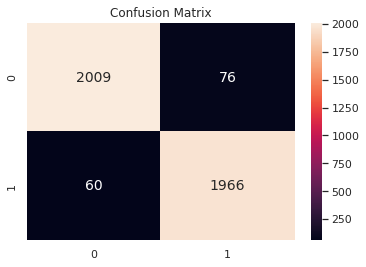


Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      2085
           1       0.96      0.97      0.97      2026

    accuracy                           0.97      4111
   macro avg       0.97      0.97      0.97      4111
weighted avg       0.97      0.97      0.97      4111



In [15]:
# Creating confusion matrix with columns as True Positive, False Negative, False Positive and True Negative 
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
plt.show()
# Creating classification report
print('\nClassification Report: \n', classification_report(y_test, (y_pred > 0.5)))

We got 2009 articles correctly identified as fake and 1966 correctly identified as real. When doing such a classification, it is important to check that we limit the number of false positives as they can cause facts to be marked as fake.

Source [Fake News Detection](https://medium.com/analytics-vidhya/fake-news-detector-cbc47b085d4)